In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [3]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, time_steps, d_model=128, nhead=4, num_layers=3, latent_dim=64, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)  # Project feature dim (1) to d_model
        self.pos_encoder = PositionalEncoding(d_model, max_len=time_steps)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,
            activation="gelu", batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Latent Space Projection (Global Pooling to get a single vector)
        self.latent_proj = nn.Linear(d_model, latent_dim)  # Reduce d_model → latent_dim
        self.latent_norm = nn.LayerNorm(latent_dim)  # Normalize latent space

        # Reverse Projection for Decoder Input
        self.mult_latent = 10
        self.reverse_proj = nn.Linear(latent_dim, d_model)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,
            activation="gelu", batch_first=True, norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output Projection
        self.output_proj = nn.Linear(d_model, 1)

        # Normalization layers
        self.encoder_norm = nn.LayerNorm(d_model)
        self.decoder_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        """
        x: [batch_size, num_features=1, time_steps]
        """
        # Prepare input: [batch, time_steps, features]
        x = x.permute(0, 2, 1)
        x = self.input_proj(x)  # Project input to d_model
        x = self.pos_encoder(x)

        # Encoder Forward Pass
        enc_output = self.encoder(x)  # [batch, time_steps, d_model]
        enc_output = self.encoder_norm(enc_output)

        # Global Mean Pooling to obtain a latent vector
        # latent = enc_output.mean(dim=1, keepdim=True)  # [batch, 1, d_model] # TODO: instead of taking the mean across the time dimension, take the first 10 entries of the time dimension, and then reshape after the next latent_proj to get [batch, 1, latent_dim * 10]
        if enc_output.shape[1] < self.mult_latent:
          enc_output = enc_output.repeat(1, math.ceil(self.mult_latent / enc_output.shape[1]), 1)
          enc_output = enc_output[:,:self.mult_latent, :]
        latent = enc_output[:,:self.mult_latent,:]
        # Project to latent space and normalize → this is the true latent representation
        latent_code = self.latent_proj(latent)       # [batch, 10, latent_dim]
        latent_code = self.latent_norm(latent_code)
        latent_result = latent_code.view(latent_code.shape[0], -1)

        # Prepare input for the decoder: use reverse projection on the latent_code
        decoder_input = self.reverse_proj(latent_code)  # [batch, 10, d_model]

        # Expand decoder input back to sequence length
        repeated_decoder_input = decoder_input.repeat(1, math.ceil(x.shape[1] / self.mult_latent), 1)
        repeated_decoder_input = repeated_decoder_input[:,:x.shape[1],:] # [batch, time_steps, d_model]
        # Break symmetry: apply positional encoding to the repeated latent representation
        repeated_decoder_input = self.pos_encoder(repeated_decoder_input)

        # Decoder Forward Pass
        # Instead of using enc_output as memory (which comes before the bottleneck), we now use
        # repeated_decoder_input for both target and memory so the decoder solely relies on the bottleneck.
        dec_output = self.decoder(repeated_decoder_input, repeated_decoder_input)  # [batch, time_steps, d_model]
        dec_output = self.decoder_norm(dec_output)

        # Output Projection
        out = self.output_proj(dec_output)  # [batch, time_steps, 1]
        out = out.permute(0, 2, 1)  # Convert back to [batch, 1, time_steps]

        # Return both the reconstructed output and the latent representation (squeezed to remove the time dim)
        return out, latent_result

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
rus1000 = pd.read_csv("/content/RUSSELL_1000_5y.csv")
spy500 = pd.read_csv("/content/SPY_500_5y.csv")

<ipython-input-5-7ea928f6593c>:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263

In [6]:
y = spy500.iloc[0,1:]
y = y[np.logical_not(spy500.iloc[2:,1:].isna().any(axis=0))].tolist()
X = spy500.iloc[2:,1:].dropna(axis=1).T.astype(float)
X = X / X.iloc[:,0].values.reshape(488, 1)
X_t, X_v, y_t, y_v = train_test_split(X.values, y, test_size=0.3, random_state=0)
X_t = X_t.reshape(X_t.shape[0], 1, X_t.shape[-1])
X_v = X_v.reshape(X_v.shape[0], 1, X_v.shape[-1])

In [7]:
model = TransformerAutoencoder(X_t.shape[2]).to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [8]:
# outputs_temp, latent_temp = model(torch.zeros(32,1,5).to(device))

In [9]:
# outputs_temp.shape, latent_temp.shape

In [10]:
train_dataset = TensorDataset(torch.tensor(X_t, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_v, dtype=torch.float32))
all_dataset = TensorDataset(torch.tensor(X.values.reshape(X.shape[0], 1, X.shape[-1]), dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
all_loader = DataLoader(all_dataset, batch_size=32, shuffle=False)

In [11]:
def train_autoencoder(model, train_loader, val_loader, num_epochs=50, lr=1e-4, device="cuda"):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for (batch, ) in train_loader:
            x = batch.to(device)  # Move batch to GPU/CPU
            optimizer.zero_grad()
            outputs, _ = model(x)  # Forward pass
            loss = criterion(outputs, x)  # Compare to original input
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()

        # Compute average training loss
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (batch, ) in val_loader:
                x = batch.to(device)
                outputs, _ = model(x)
                loss = criterion(outputs, x)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Print epoch losses
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    return model

In [12]:
# model = train_autoencoder(model, train_loader, val_loader, num_epochs=50, lr=1e-4, device=device)

In [13]:
# X_temp = next(iter(val_loader))[0].to(device)
# outputs, latent = model(X_temp)

In [14]:
# torch.nn.CosineSimilarity(dim=2)(X_temp, outputs)

In [15]:
# torch.linalg.norm(X_temp), torch.linalg.norm(outputs)

In [16]:
# torch.save(model.state_dict(), "model.pth")
model.load_state_dict(torch.load("/content/model.pth copy"))

<ipython-input-16-0fc42efbcdad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/model.pth copy"))


<All keys matched successfully>

In [17]:
# X_t.shape

In [18]:
model.eval()
latents = []
avg_daily_percent_change = []
overall_percent_change = []
train_val = [0 for i in range(len(train_loader.dataset))] + [1 for i in range(len(val_loader.dataset))]

special_idx = 1
ref = torch.tensor(X_t[special_idx], dtype=torch.float32).unsqueeze(0).to(device)
ref = ref.view(ref.shape[0],-1)
ref_mean = ref.mean()
ref_std = ref.std()
corrs = []

# with torch.no_grad():
#     for (batch, ) in all_loader:
#         x = batch.to(device)
#         output, latent = model(x)
#         # print(latent.shape)
#         latents.append(latent.cpu().detach().numpy())
#         avg_daily_percent_change += (x.diff() / x[:,:,:-1]).mean(dim=-1).flatten().tolist()
#         overall_percent_change += ((x[:,:,-1] - x[:,:,0]) / x[:,:,0]).flatten().tolist()
with torch.no_grad():
    for (batch, ) in train_loader:
        x = batch.to(device)
        output, latent = model(x)
        # print(latent.shape)
        latents.append(latent.cpu().detach().numpy())
        avg_daily_percent_change += (x.diff() / x[:,:,:-1]).mean(dim=-1).flatten().tolist()
        overall_percent_change += ((x[:,:,-1] - x[:,:,0]) / x[:,:,0]).flatten().tolist()
        others = x.view(x.shape[0], -1)
        others_mean = others.mean(dim=1, keepdim=True)
        others_std = others.std(dim=1, keepdim=True)
        cov = ((others - others_mean) * (ref - ref_mean)).sum(dim=1) / (others.shape[-1] - 1)
        corr = cov / (ref_std * others_std.squeeze())
        corrs += corr.tolist()

with torch.no_grad():
    for (batch, ) in val_loader:
        x = batch.to(device)
        output, latent = model(x)
        # print(latent.shape)
        latents.append(latent.cpu().detach().numpy())
        avg_daily_percent_change += (x.diff() / x[:,:,:-1]).mean(dim=-1).flatten().tolist()
        overall_percent_change += ((x[:,:,-1] - x[:,:,0]) / x[:,:,0]).flatten().tolist()
        others = x.view(x.shape[0], -1)
        others_mean = others.mean(dim=1, keepdim=True)
        others_std = others.std(dim=1, keepdim=True)
        cov = ((others - others_mean) * (ref - ref_mean)).sum(dim=1) / (others.shape[-1] - 1)
        corr = cov / (ref_std * others_std.squeeze())
        corrs += corr.tolist()
latents = np.concatenate(latents)
overall_percent_change_clipped = np.clip(overall_percent_change, np.percentile(overall_percent_change, 5), np.percentile(overall_percent_change, 95))
tickers = pd.Series(y_t + y_v)
X_total = np.concatenate((X_t, X_v))

In [19]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [20]:
pca = PCA(n_components=2)
latents_transformed = pca.fit_transform(latents)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.90409714 0.05653367]
0.96063083


In [21]:
latents.shape, latents_transformed.shape

((488, 640), (488, 2))

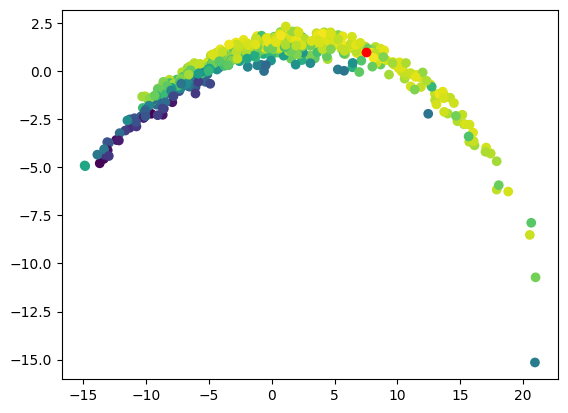

In [22]:
plt.scatter(latents_transformed[:,0], latents_transformed[:,1], c=corrs)
plt.scatter(latents_transformed[special_idx,0], latents_transformed[special_idx,1], c="red")

(array([ 10.,  12.,  16.,  23.,  18.,  21.,  25.,  81., 118., 164.]),
 array([-0.65927571, -0.49334812, -0.32742052, -0.16149293,  0.00443467,
         0.17036226,  0.33628986,  0.50221745,  0.66814505,  0.83407264,
         1.00000024]),
 <BarContainer object of 10 artists>)

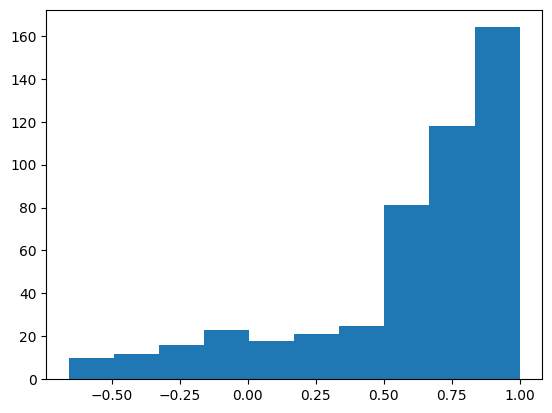

In [23]:
plt.hist(corrs)

In [24]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(latents)

KMeans(n_clusters=10)

In [25]:
def elbow_curve(latents):
  cluster_nums = []
  inertias = []
  for i in range(2,min(20,latents.shape[0])):
    cluster_nums.append(i)
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(latents)
    inertias.append(kmeans.inertia_)
  percent_changes = np.diff(inertias) / inertias[:-1]
  threshold = 0.2
  cluster_decision = np.array(cluster_nums[1:])[percent_changes > -threshold]
  cluster_decision = cluster_decision[0] if cluster_decision.size > 0 else 1
  fewest_per_cluster = 3
  if latents.shape[0] < fewest_per_cluster:
    cluster_decision = 1
  kmeans = KMeans(n_clusters=cluster_decision)
  kmeans.fit(latents)
  return inertias, percent_changes, cluster_nums, cluster_decision, kmeans

In [26]:
inertias, percent_changes, cluster_nums, cluster_decision, kmeans = elbow_curve(latents)

In [27]:
def recursive_clustering(latents, depth=3):
  inertias, percent_changes, cluster_nums, cluster_decision, kmeans = elbow_curve(latents)
  clusters = np.concatenate((kmeans.labels_.reshape(-1,1), np.zeros((kmeans.labels_.shape[0],depth-1))), axis=1)
  if depth == 1:
    return clusters
  for i in range(cluster_decision):
    clusters_temp = recursive_clustering(latents[kmeans.labels_ == i], depth=depth-1)
    clusters[kmeans.labels_ == i,1:] = clusters_temp
  return clusters

In [28]:
clusters = recursive_clustering(latents, depth=2)
clusters = [tuple(i) for i in clusters.astype(int).tolist()]

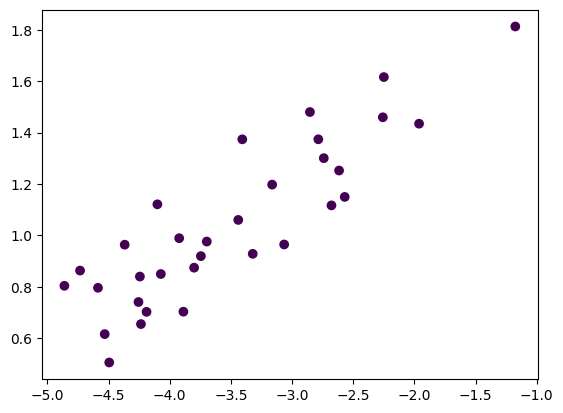

In [29]:
idxs = [i for i in range(len(clusters)) if clusters[i] == (1,0)]
plt.scatter(latents_transformed[idxs,0], latents_transformed[idxs,1], c=[clusters[i][1] for i in idxs])

38


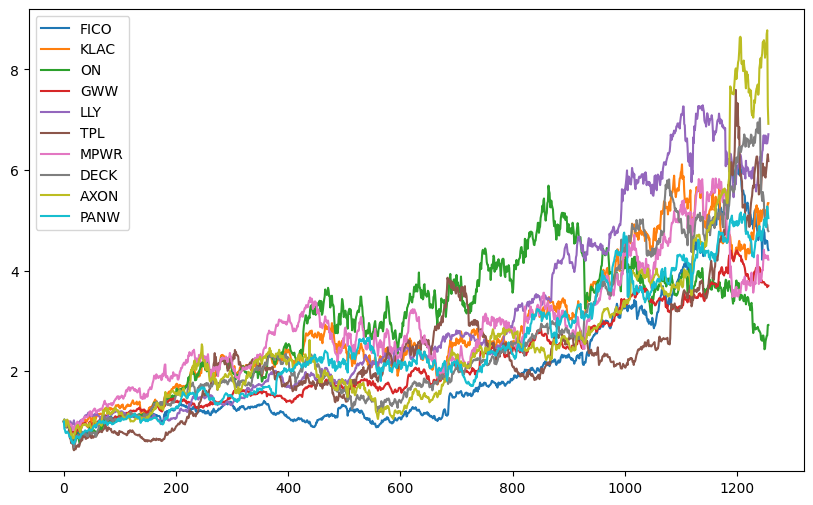

['FICO', 'KLAC', 'ON', 'GWW', 'LLY', 'TPL', 'MPWR', 'DECK', 'AXON', 'PANW']
['MPWR', 'IRM', 'CRWD', 'GWW', 'FCX', 'BLDR', 'DELL', 'FSLR', 'EQT', 'LRCX', 'MRNA', 'VST', 'DVN', 'PANW', 'SMCI', 'KLAC', 'CDNS', 'ANET', 'SNPS', 'LLY', 'URI', 'PWR', 'TSCO', 'AXON', 'FICO', 'ENPH', 'NVDA', 'NUE', 'AVGO', 'JBL', 'FTNT', 'ON', 'STLD', 'KKR', 'TRGP', 'TPL', 'DECK', 'TSLA']


In [32]:
plt.figure(figsize=(10,6))
cluster_num = 1
# idxs = [i for i in range(len(clusters)) if clusters[i] in [(0,i) for i in range(10)]]
idxs = [i for i in range(len(clusters)) if clusters[i] in [(0,0)]]
print(len(idxs))
rows_select = np.random.choice(idxs,min(10,len(idxs)),replace=False)
plt.plot(X_total[rows_select,0,:].T, label=tickers.iloc[rows_select].tolist())
plt.legend(loc="upper left")
plt.show()
print(tickers.iloc[rows_select].tolist())
print(tickers[idxs].tolist())

In [76]:
le = LabelEncoder()
clusters_numbered = le.fit_transform([" ".join([str(j) for j in i[:1]]) for i in clusters])

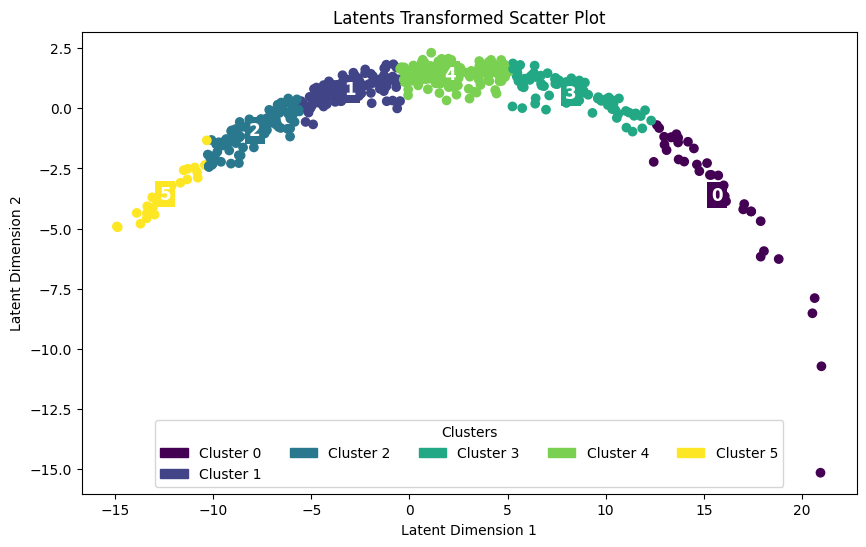

In [77]:
# plt.scatter(latents_transformed[:,0], latents_transformed[:,1], c=clusters_numbered)
# plt.colorbar()

plt.figure(figsize=(10, 6))

# Assume clusters_numbered is a 1D array of cluster labels and
# latents_transformed is a 2D array with shape [n_samples, 2]
unique_clusters = np.unique(clusters_numbered)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Create the scatter plot without legend
scatter = plt.scatter(latents_transformed[:, 0], latents_transformed[:, 1],
                      c=clusters_numbered, cmap='viridis')

# Create legend handles for each cluster
handles = [mpatches.Patch(color=colors[i], label=f'Cluster {uc}')
           for i, uc in enumerate(unique_clusters)]
plt.legend(handles=handles, title='Clusters', loc="lower center", ncol=5)

# For each cluster, compute the centroid and plot the cluster number
for i, cluster in enumerate(unique_clusters):
    # Select points that belong to the current cluster
    cluster_mask = clusters_numbered == cluster
    cluster_points = latents_transformed[cluster_mask]

    # Compute centroid coordinates
    centroid_x = cluster_points[:, 0].mean()
    centroid_y = cluster_points[:, 1].mean()

    # Plot the cluster number at the centroid
    plt.text(centroid_x, centroid_y, str(cluster),
             fontsize=12, fontweight='bold', color='white',
             ha='center', va='center',
             bbox=dict(facecolor=colors[i], edgecolor='none', pad=3))

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latents Transformed Scatter Plot')
plt.show()

In [78]:
# np.sort(clusters[clusters[:,0] == 0], axis=0)

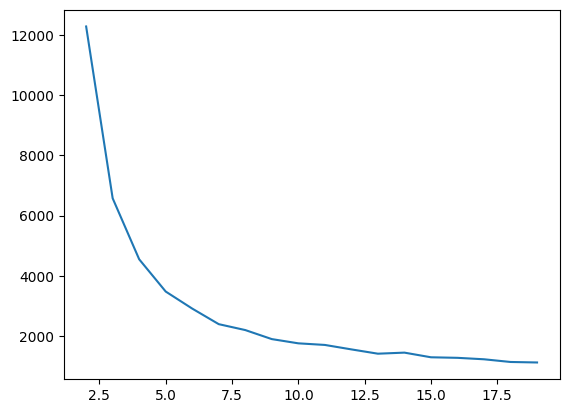

In [62]:
  plt.plot(cluster_nums, inertias)

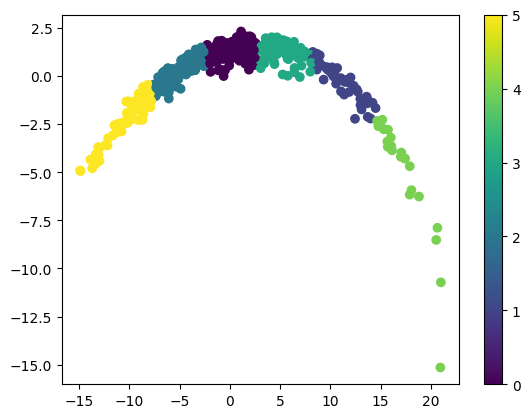

In [63]:
plt.scatter(latents_transformed[:,0], latents_transformed[:,1], c=kmeans.labels_)
plt.colorbar()
plt.show()

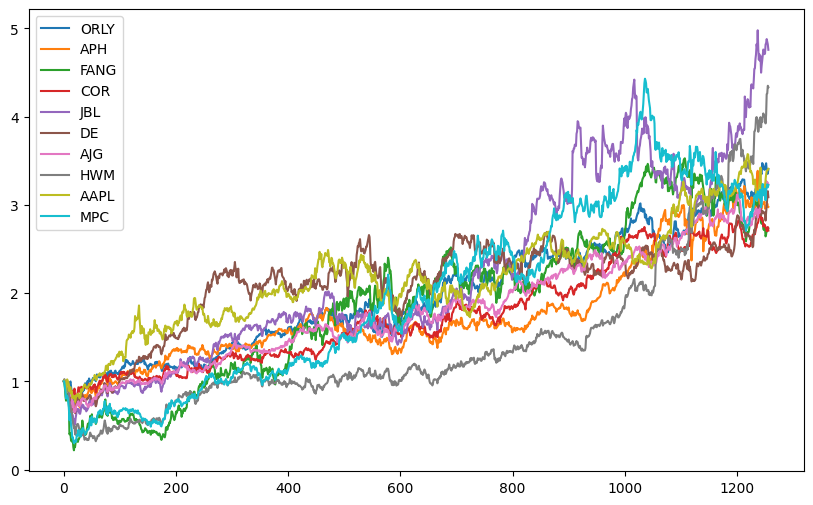

['ORLY', 'APH', 'FANG', 'COR', 'JBL', 'DE', 'AJG', 'HWM', 'AAPL', 'MPC']
['ETN', 'NOW', 'BX', 'CF', 'IRM', 'DHI', 'CTAS', 'PH', 'DE', 'GWW', 'AJG', 'CAT', 'AMP', 'ODFL', 'PHM', 'LRCX', 'MSFT', 'VST', 'DVN', 'PANW', 'AZO', 'IT', 'SNPS', 'CMG', 'PGR', 'ORLY', 'TSCO', 'AAPL', 'FICO', 'ENPH', 'GE', 'APH', 'AMAT', 'COR', 'ORCL', 'JBL', 'FTNT', 'APO', 'WMB', 'HWM', 'HUBB', 'FANG', 'KKR', 'AMD', 'MPC', 'TRGP', 'HES', 'MCK', 'TT', 'COST', 'TPL', 'ERIE']


In [64]:
plt.figure(figsize=(10,6))
cluster_num = 1
idxs = [i == cluster_num for i in kmeans.labels_]
idxs2 = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == cluster_num]
rows_select = np.random.choice(idxs2,min(10,len(idxs2)),replace=False)
plt.plot(X_total[rows_select,0,:].T, label=tickers.iloc[rows_select].tolist())
plt.legend(loc="upper left")
plt.show()
print(tickers.iloc[rows_select].tolist())
print(tickers[idxs].tolist())

In [65]:
X_total[rows_select,0,:].shape

(10, 1257)

In [ ]:
# TODO: get back stock names for clusters and see if they make sense
# TODO: elbow method for number of clusters
# TODO: train model for longer
# TODO: feed tickers for each cluster into LLM and decide name for clusters
# TODO: do recursive/hierarchical clustering, then do labeling

In [66]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [67]:
linkage_matrix = linkage(latents, method="ward")

In [68]:
linkage_matrix.shape

(487, 4)

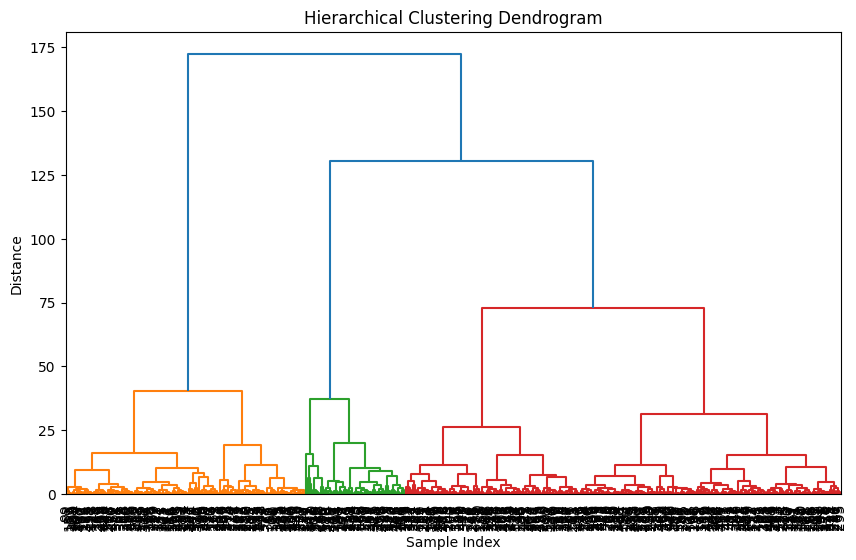

In [69]:
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

In [70]:
import plotly.figure_factory as ff

In [71]:
spy_tickers = pd.read_csv("sp500_tickers.csv")

In [72]:
dendrogram_labels = spy_tickers.iloc[[int(i[i.index(".")+1:]) if "." in i else 0 for i in X.index]].values

In [73]:
fig = ff.create_dendrogram(linkage_matrix, labels=dendrogram_labels[1:], orientation="bottom")

fig.update_layout(
    width=1200,
    height=600,
    title="Interactive Hierarchical Clustering Dendrogram",
    xaxis=dict(tickangle=-90, showticklabels=True)
)

fig.show()